# Example: Binomial Lattice Simulation of Equity Share Price using Real-World Probabilities
In this example, we will construct a binomial lattice model to simulate future equity share prices using real-world probabilities estimated from historical data.

> __Learning objectives__
> The objective of this example is to familiarize students with applying simple probability mass functions to predict future uncertain quantities such as commodity prices, equity share prices, interest rates, etc. After completing this example, students should be able to:

> * Understand the structure and implementation of binomial lattice models for asset price prediction
> * Estimate real-world probabilities and move magnitudes from historical stock price data
> * Build and populate binomial trees using estimated parameters
> * Compare model predictions with actual market observations
> * Evaluate model performance using statistical confidence intervals

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # nrow? (check out: DataFrames.jl)

2767

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # what is this doing?
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

How many firms do we have the full number of trading days? Let's use [the `length(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.length) - notice this works for dictionaries, in addition to arrays, sets and other collections.

In [5]:
length(dataset) # tells us how many keys are in the dictionary (how many firms in our dataset?)

424

Finally, let's get a list of the firms in our cleaned up dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [6]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, permissible values, etc.

In [7]:
TSIM = 63; # number of trading days to simulate
Δt = (1.0/252); # step size: 1-trading day in units of years

___

## Task 1: Test the lattice model using an example from `Hull`
Let’s start by calculating the hypothetical share price from an example (reproduced from Chapter 13 of Hull) before diving into historical data analysis. The lattice in this example has three levels (`L=0,1,2`), with an initial share price of $S_{\circ}=20.0$ USD. An `up` move has a probability of `p = 0.6523` and a magnitude of `u = 1.1`, while a `down` move has a magnitude of `d = 0.9`.

Calculating the future share price with a binomial lattice requires setting the model’s parameters, including the initial share price (as a `Float64`), the number of time steps to simulate into the future, which equals the number levels of the tree starting from zero (as an `Int64`), the up and down move magnitudes (as `Float64` values), and the probability of an up move (as a `Float64`):

In [8]:
Sₒ,T,u,d,p = 20.0,2,1.1,0.9,0.6523;

Once these values are set, we use the `build(…)` function to create an empty lattice model of [type `MyBinomialEquityPriceTree`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree), which is then passed to [the `populate(…)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.populate-Tuple{MyBinomialEquityPriceTree}) using the [Julia piping `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). 

The [`populate(…)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.populate-Tuple{MyBinomialEquityPriceTree}) calculates the prices and probabilities of each node, which are of [type `MyBinomialLatticeEquityNodeModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialLatticeEquityNodeModel), in the tree:

In [9]:
test_hull_model = build(MyBinomialEquityPriceTree, (
        u = u, d = d, p = p)) |> (x-> populate(x, Sₒ = Sₒ, h = T));

### Check: Do we reproduce the `Hull` tree values?
Let's compare the price values we calculated to those reported by Hull. First, we populate the `hull_price_dictionary` dictionary, which holds `key=>value` pairs encoding the data for each node in the tree. In this dictionary, the `keys` are the node indices, while the `values` in the dictionary are the price values at that node:

In [10]:
hull_price_dictionary = Dict(0=>20.0, 1=>22.0,2=>18.0,3=>24.2,4=>19.8,5=>16.2);

Now, let's populate the `hull_test_data_table` variable, which is of [type `DataFrame`](https://dataframes.juliadata.org/stable/), and display the contents using [the `pretty_table(...)` method, exported by PrettyTable.jl package](https://github.com/ronisbr/PrettyTables.jl) within a `for` loop. 

For each iteration of the for loop:
* We capture the node index `i`, the share price from `Hull`, and our computed price at that node from the binomial tree
* We use the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox), with a relative tolerance `rtol = 1e-4`, to check if our computed price agrees with the price reported by Hull. If yes, a value of `true` is reported, otherwise `false`

What do we observe?

In [11]:
let

    # initialize -
    number_of_nodes = length(test_hull_model.data);
    hull_test_data_table = DataFrame();
    
    # populate the DataFrame (by rows)
    for i ∈ 0:(number_of_nodes-1)
        
        row_data = (
            node = i,
            hull_price = hull_price_dictionary[i],
            our_price =  test_hull_model.data[i].price, 
            isapproxequal = isapprox(hull_price_dictionary[i], test_hull_model.data[i].price, rtol=1e-4)
        );
        
        push!(hull_test_data_table, row_data)
    end
    pretty_table(hull_test_data_table, backend = :text,
            table_format = TextTableFormat(borders = text_table_borders__compact))
end;

 ------- ------------ ----------- ---------------
   node   hull_price   our_price   isapproxequal 
  Int64      Float64     Float64            Bool 
 ------- ------------ ----------- ---------------
      0         20.0        20.0            true
      1         22.0        22.0            true
      2         18.0        18.0            true
      3         24.2        24.2            true
      4         19.8        19.8            true
      5         16.2        16.2            true
 ------- ------------ ----------- ---------------


___

## Task 2: Estimate the `up,` `down,` and probability of an up move `p` for a random firm, and simulate the future share price
After validating our lattice implementation, it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we must estimate three critical parameters: $p$, $u$, and $d$.

* The $p$ parameter represents the probability of a share price increase or an `up` move between two periods $j\rightarrow{j+1}$. As a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
* The $u$ parameter represents the amount of an `up` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move will give $S_{j+1} = u\cdot{S}_{j}$.
* The $d$ parameter represents the amount of a `down` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move will give $S_{j+1} = d\cdot{S}_{j}$.

To start, let's select a firm from the dataset to explore. 

In [12]:
# random_firm_ticker = rand(list_of_all_tickers);
random_firm_ticker = "SPY"
random_firm_index = findfirst(x-> x == random_firm_ticker, list_of_tickers);
random_firm_data = dataset[random_firm_ticker];

In [22]:
random_firm_data

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,8.16791e7,183.088,183.21,182.885,183.6,182.63,2014-01-03T05:00:00,224668
2,1.08262e8,182.664,183.47,182.36,183.56,182.08,2014-01-06T05:00:00,279442
3,8.63668e7,183.305,183.09,183.48,183.79,182.95,2014-01-07T05:00:00,243474
4,9.68343e7,183.455,183.45,183.52,183.83,182.89,2014-01-08T05:00:00,277709
5,9.1021e7,183.478,184.1,183.64,184.13,182.795,2014-01-09T05:00:00,262778
6,1.02118e8,183.697,183.95,184.14,184.22,183.01,2014-01-10T05:00:00,275019
7,1.50213e8,182.726,183.71,181.685,184.18,181.34,2014-01-13T05:00:00,367981
8,1.01254e8,182.99,182.28,183.67,183.77,181.95,2014-01-14T05:00:00,277201
9,9.87154e7,184.48,184.1,184.66,184.94,184.01,2014-01-15T05:00:00,249347


### Estimate the u, d, and probability p parameters from the data
Let's estimate the up $u$, down $d$ factors and the probability $p$ from historical data.

__Initialize__: Given the growth rate sequence $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ for firm $(i)$ (we neglect the superscript $i$ for simplicity) and a time step $\Delta{t} > 0$ (units: years). Initialize the up factors collection $U = \emptyset$ and down factors collection $D = \emptyset$.

1. For $t = 2,3,\dots,T$ __do__:
    - If $\mu_{t} > 0$, then update $U \leftarrow U \cup \{e^{\mu_{t}\Delta{t}}\}$ where $U$ is a collection of up factors.
    - If $\mu_{t} < 0$, then update $D \leftarrow D \cup \{e^{\mu_{t}\Delta{t}}\}$ where $D$ is a collection of down factors.
    - If $\mu_{t} = 0$, skip (no price change).
2. Compute the up factor $u$ as the mean of the up factors collection $U$: $u = \frac{1}{|U|} \sum_{v \in U} v$.
3. Compute the down factor $d$ as the mean of the down factors collection $D$: $d = \frac{1}{|D|} \sum_{v \in D} v$.
4. Compute the probability $p$ as the fraction of up movements: $p = \frac{|U|}{|U| + |D|}$.

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that occurs in a single trading day.

The [`log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) takes the cleaned dataset $\mathcal{D}$, which contains $T$ days of data for each firm, a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. 

The data is returned as a $(T - 1)\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array::Array{Float64,1}` variable:

In [13]:
log_growth_array = log_growth_matrix(dataset, random_firm_ticker); # array holding growth rate time series

Using the `log_growth_array::Array{Float64,1}`, we compute the expected magnitude of an up move $\bar{u}$, the expected magnitude of a down move $\bar{d}$, and the estimated probability $\bar{p}$ of an up move (assuming a real-world probability measure) by passing the return data to [a `RealWorldBinomialProbabilityMeasure` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.RealWorldBinomialProbabilityMeasure), which returns the $(u,d,p)$ tuple.

> __Syntax sugar__: Behind the scenes, this call points to a private function that computes $\bar{u}$, $\bar{d}$, and $\bar{p}$ by analyzing the growth rate time series data in the `log_growth_array::Array{Float64,1}` variable. It looks like we are using a type as a function name, but we are not. This is a neat Julia trick, right?

What values did we obtain for our random firm?

In [14]:
(ū,d̄,p̄) = (RealWorldBinomialProbabilityMeasure())(log_growth_array; Δt = (1.0/252.0))

(1.005564502936516, 0.9938360721560962, 0.564352856109906)

### Build binomial lattice model using historical $(u,d,p)$ parameters
Let's construct an instance of [the `MyBinomialEquityPriceTree` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using the estimated values for `(u,d,p)`. This enables us to calculate the prices and probabilities in the tree. We store the populated model in the variable `model` for future use.

First, we set a value for the `T` variable, specifying the number of future days to simulate. Time steps are represented in the tree as levels `L = 0,1,..., T`, where each level represents $\Delta{t}$ units of time, which is a trading day. 

Next, we specify the `start_index` as the trading day index in the dataset, which will serve as the tree's starting point or `L = 0`. Finally, we set the variable `Sₒ`, which corresponds to the initial price per share at the root of the tree; we use the [volume-weighted average price (VWAP)](https://en.wikipedia.org/wiki/Volume-weighted_average_price) as the initial condition:

In [ ]:
start_index = rand(1:(maximum_number_trading_days - TSIM - 1))
stop_index = start_index + TSIM
println("Visualize Firm-$(random_firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-350 between trading days (2691 -> 2754)


In [16]:
Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
random_test_model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (model -> populate(model, Sₒ = Sₒ, h = TSIM));
println("Starting simulation from Sₒ = $(Sₒ) USD/share")

Starting simulation from Sₒ = 556.9473 USD/share


#### Visualize price distribution at tree level L
`Unhide` the code block below to see how we plotted the distribution of possible share prices and their associated probabilities at the final level of our binomial tree. 

> __What do we expect?__ We expect to see a discrete probability distribution where each possible price outcome has a specific probability based on the number of paths that lead to that price level. The distribution should reflect the binomial nature of our model, with probabilities concentrated around the most likely price outcomes.

What do we observe?

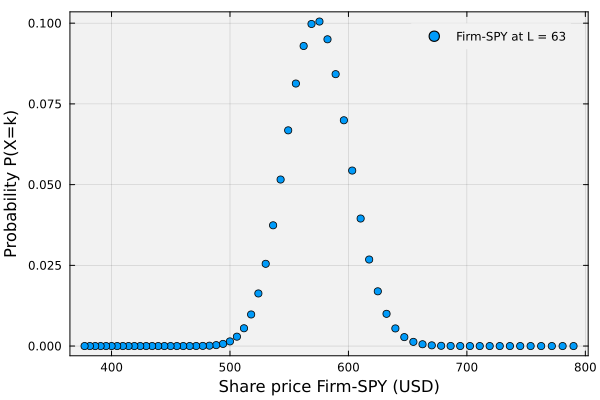

In [17]:
let
    L = TSIM;
    price_array = random_test_model.levels[L] .|> x-> random_test_model.data[x].price
    probability_array = random_test_model.levels[L] .|> x-> random_test_model.data[x].probability;
    scatter(price_array, probability_array, label="Firm-$(random_firm_ticker) at L = $(L)")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Share price Firm-$(random_firm_ticker) (USD)", fontsize=18)
    ylabel!("Probability P(X=k)", fontsize=18)
end

### Visualize binomial lattice simulation
Next, look at how the binomial model simulations compare with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time, i.e., at each level in the tree using the local [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl).

The `levels` array holds the index of the tree levels, i.e., the time slices. The [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl) take the `random_test_model` tree model, and the `levels` array and return the expectation and the variance, respectively. 

In [18]:
levels = [k for k ∈ 0:(TSIM-1)]
expectation = 𝔼(random_test_model, levels); # compute the expected value
variance = Var(random_test_model, levels); # compute the variance

#### Summary
`Unhide` the code block below to see how we plotted the model simulations and the observed prices for a randomly selected firm using a binomial lattice model.

The dashed line is the expected share price predicted by the lattice model, while the shaded regions denote $\mu\pm{z}\cdot\sigma$ for $z=$ `1.0, 1.96, 2.576`. The solid red line with circles is the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for this firm and date range.

Depending upon the random ticker, the observed price (red line with points) may or may not lie within the $\pm\,{z}\cdot\sigma$ confidence ranges, where `z = {1, 1.96, 2.576}` are shown in progressively lighter shades of blue. The dashed dark blue line shows the expected value.

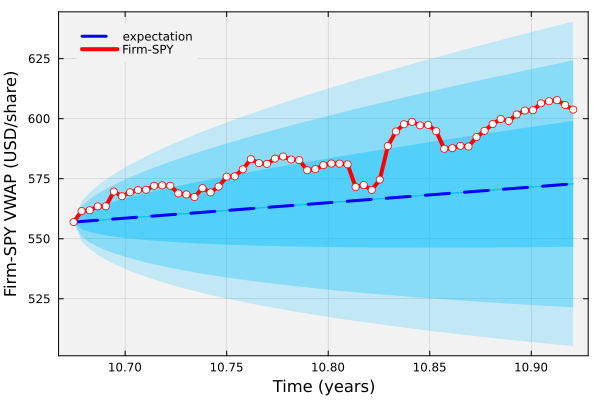

In [21]:
let 

    # initialize -
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    T_range = range(start_index,stop=stop_index-1,step=1) |> collect 
    T_sim = T_range*Δt .- Δt

    plot(T_sim, expectation[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(T_sim, expectation[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(T_sim, expectation[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(T_sim, expectation[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(T_sim, expectation[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(T_sim, expectation[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(T_sim, expectation[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price],  
        lw=4, c=:red, label="Firm-$(random_firm_ticker)", legend = :topleft)
    scatter!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price], label="", 
        msc=:red, mc=:white)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)
end

### Check: Was this a successful simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward, functional test. 

> __Functional test__
> 
> * __Success__: if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$), then the model is deemed a `success.`
> * __Failure__: However, if the actual price exceeds the given bounds __at any point__, the simulation is considered a `failure.`

So, did we succeed or fail?

In [20]:
let
    z = 2.576
    L = expectation[:,2] .- z*sqrt.(variance[:,2])
    U = expectation[:,2] .+ z*sqrt.(variance[:,2])
    
    # check the bounds: if below L, or above U then simulation failed
    success_flag = true;
    for k ∈ 1:TSIM
        
        price_value = random_firm_data[start_index+k-1,:volume_weighted_average_price];    
        if (price_value < L[k]) || (price_value > U[k])            
            success_flag = false;
            break;
        end
    end

    println("The simulation of the VWAP for $(random_firm_ticker) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")
end

The simulation of the VWAP for SPY between (2691 -> 2754) was successful: true


___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.